In [1]:
from dotenv import dotenv_values
import pandas as pd
import numpy as np
from strategy import MlDt
from binance.client import Client
import datetime
from dataset import Dataset

# Download data

In [2]:
data_binance = Dataset()
data = data_binance.get_data(days=90, ticker='SFPUSDT', ts='1H')

# Initialization strategy

In [3]:

strategy_ml = MlDt(threshold=0.003)


## Create Rules for Mean Reversing strategy

In [4]:
strategy_ml._save_rules(
    data=data,
    rules=50,
    reverse=False
)

Rules:  1
Backtest result:  0.5317812441445549
Rules:  2
Backtest result:  0.6304013852933569
Rules:  3
Backtest result:  0.895438827949233
Rules:  4
Backtest result:  0.03979861449111011
Rules:  5
Backtest result:  0.6727798096344287
Rules:  6
Backtest result:  0.6877180779800949
Rules:  7
Backtest result:  0.4895910567749272
Rules:  8
Backtest result:  0.2804011142025803
Rules:  9
Backtest result:  0.41840223213021044
Rules:  10
Backtest result:  0.4596715826750558
Rules:  11
Backtest result:  0.3560025699872216
Rules:  12
Backtest result:  0.11488189316121966
Rules:  13
Backtest result:  0.008872376816276728
Rules:  14
Backtest result:  0.2009929781482278
Rules:  15
Backtest result:  0.7379005886751713
Rules:  16
Backtest result:  0.12164982272976932
Rules:  17
Backtest result:  0.3388150523442224
Rules:  18
Backtest result:  -0.04832424789765
Rules:  19
Backtest result:  0.27146416346378044
Rules:  20
Backtest result:  0.05758339033313786
Rules:  21
Backtest result:  0.287244063466

2021-04-25 15:04:30.939 | INFO     | strategy:backtest:367 - Backtest using signal method


<AxesSubplot:xlabel='time'>

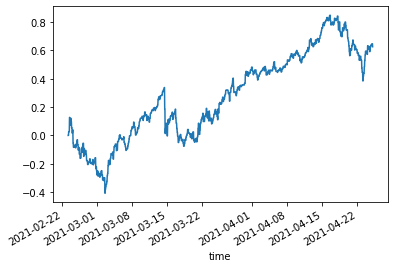

In [5]:
backtest_data = strategy_ml.backtest(data=data, comission=0,  takeProfit=0.03,
                lag=12, stopLoss=-0.02, exitPosition="signal", ml=False)
backtest_data['cumsum'].plot()

## Create Machine learning model

2021-04-25 11:11:23.913 | INFO     | strategy:backtest:367 - Backtest using signal method


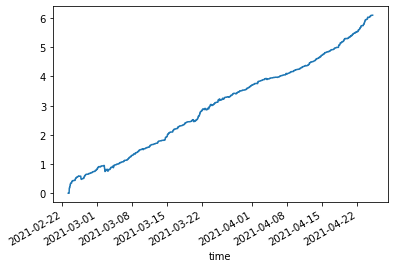

In [55]:
strategy_ml.create_machine_learning_models(data=data, split_train=1)

## Backtest

2021-04-25 15:06:04.142 | INFO     | strategy:backtest:367 - Backtest using signal method


<AxesSubplot:xlabel='time'>

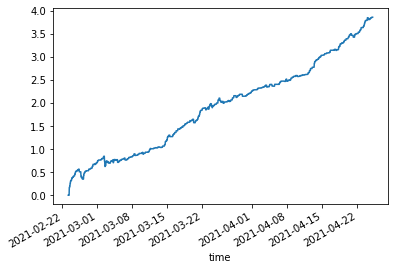

In [6]:
backtest_data = strategy_ml.backtest(data=data, comission=0.01,  takeProfit=0.02,
                lag=12, stopLoss=-0.02, exitPosition="signal", ml=True)
backtest_data['cumsum'].plot()

<AxesSubplot:xlabel='time'>

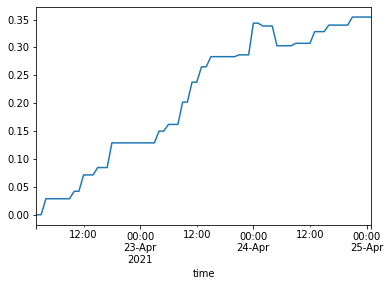

In [7]:
backtest_data.last('3D')['return'].cumsum().plot() # 1D, 1M, 1W, 5Min, 

In [38]:
data.loc[data['signal'] != 0, 'signal'].value_counts(normalize=True) # balance situation 50 / 50. it is target

 1    0.519449
-1    0.480551
Name: signal, dtype: float64

In [45]:
data.loc[:, 'count_return'] = np.where(data['return'] > 0, 1, data['return'])
data.loc[:, 'count_return'] = np.where(data['return'] < 0, -1, data['count_return'])
data.loc[data['count_return'] !=0, 'count_return'].value_counts(normalize=True)

 1.0    0.84227
-1.0    0.15773
Name: count_return, dtype: float64